# Inspecting CCC patterns from spatial transcriptomics

This tutorial illustrates how Tensor-cell2cell can be used to explore cell-cell communication in distinct regions of a tissue using spatial transcriptomics. Here each region of the tissue is treated as a separate context.

## 1 - Setups

This notebook requires installing `scanpy`, `squidpy`, and `liana`.

In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import liana as li

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import squareform

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2 - Data

### RNA-seq data

Similar to [the tutorial of using LIANA and MISTy](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html), we will use an ischemic 10X Visium spatial slide from [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). It is a tissue sample obtained from a patient with myocardial infarction, specifically focusing on the ischemic zone of the heart tissue.

The slide provides spatially-resolved information about the cellular composition and gene expression patterns within the tissue.

In [3]:
adata = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')

  0%|          | 0.00/44.4M [00:00<?, ?B/s]

In [4]:
adata

AnnData object with n_obs × n_vars = 4113 × 17703
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rps', 'mrp', 'rpl', 'duplicated'
    uns: 'spatial'
    obsm: 'compositions', 'mt', 'spatial'

Normalize data

In [5]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Visualize spot clusters or niches. These niches were defined by clustering spots from their cellular composition deconvoluted by using cell2location ([Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x)).

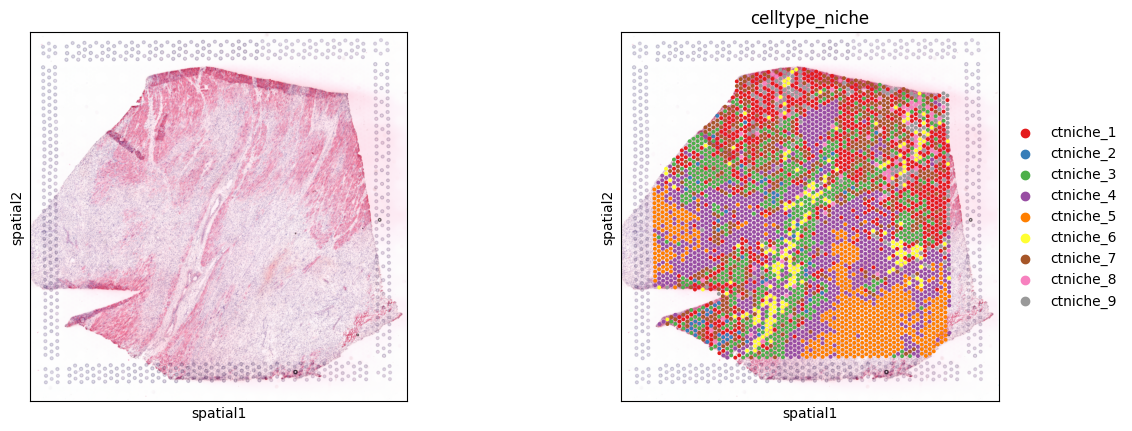

In [6]:
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

Cellular composition obtained from cell2location

In [7]:
# Rename to more informative names
full_names = {'Adipo': 'Adipocytes',
              'CM': 'Cardiomyocytes',
              'Endo': 'Endothelial',
              'Fib': 'Fibroblasts',
              'PC': 'Pericytes',
              'prolif': 'Proliferating',
              'vSMCs': 'Vascular_SMCs',
              }
# but only for the ones that are in the data
adata.obsm['compositions'].columns = [full_names.get(c, c) for c in adata.obsm['compositions'].columns]

In [8]:
comps = li.ut.obsm_to_adata(adata, 'compositions')

In [9]:
comps.var

Empty DataFrame
Columns: []
Index: [Adipocytes, Cardiomyocytes, Endothelial, Fibroblasts, Lymphoid, Mast, Myeloid, Neuronal, Pericytes, Proliferating, Vascular_SMCs]

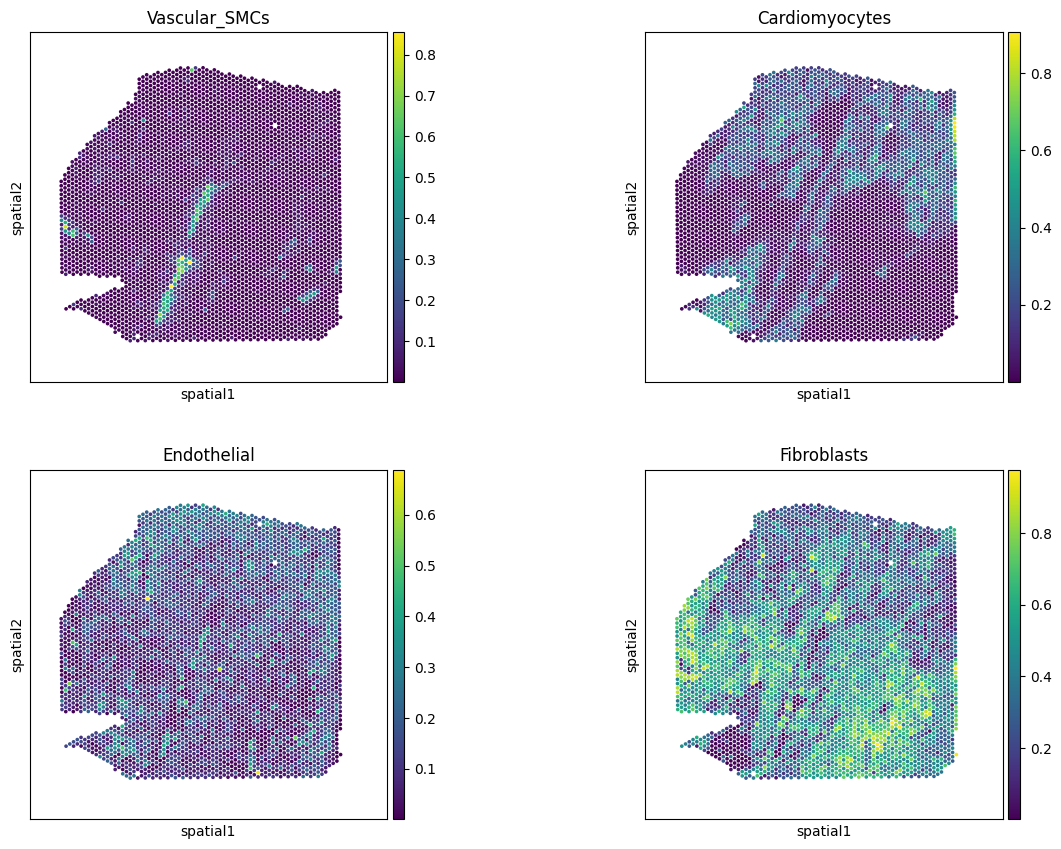

In [10]:
# check key cell types
sq.pl.spatial_scatter(comps,
                      color=['Vascular_SMCs','Cardiomyocytes',
                             'Endothelial', 'Fibroblasts'],
                      size=1.3, ncols=2, img_alpha=0
                      )

In [11]:
adata_og = adata.copy()

### Defining spatial contexts in the tissue

For defining spatial contexts within a tissue using spatial transcriptomics we simply divide the tissue in different regions through a square grid of a specific number of bins in each of the axes. 

In this case, we divide our tissue into a 5x5 grid. A new column will be create in the `adata` object, specifically `adata.obs['grid_cell']`, to assign each spot or cell a grid window.

In [12]:
num_bins = 5

In [13]:
c2c.spatial.create_spatial_grid(adata, num_bins=num_bins)

... storing 'grid_cell' as categorical


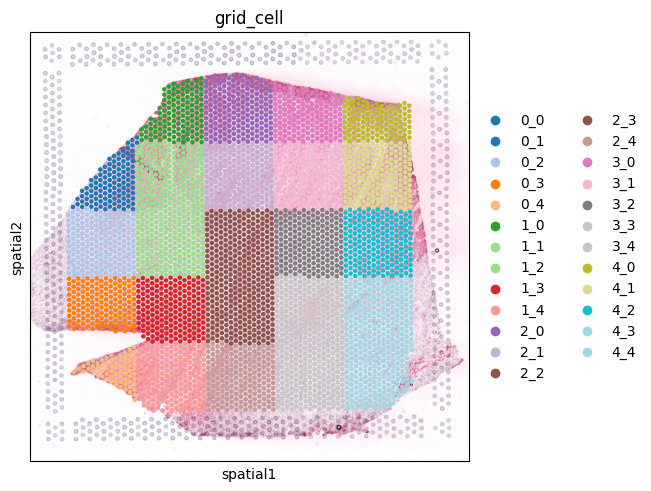

In [14]:
sq.pl.spatial_scatter(adata, color='grid_cell', size=1.3, palette='tab20')

Here, cells or spots in one grid window do not get to interact with those that are within other grid windows, ignoring that cells in the interfaces between grid windows could also interact. For accounting for those cases, more complex approaches could be employed, as for example a sliding window strategy for defining contexts. In that case, spatial contexts will present some overlap in the cells or spots that are within them.

For simplicity we only tried the grid approach, which could be replaced by the sliding windows method, but it would also require to account for the overlap between spatial contexts. If you are interested in trying out this approach, see `cell2cell.spatial.neighborhood.create_sliding_windows()` and `cell2cell.spatial.neighborhood.add_sliding_window_info_to_adata()`.

### Protein-Protein Interactions or Ligand-Receptor Pairs

In this case, we use a list of LR pairs published with CellChat (Jin et al. 2021, Nature Communications).

In [15]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')

In [16]:
lr_pairs.head()

interaction_name pathway_name ligand       receptor       agonist  \
0  TGFB1_TGFBR1_TGFBR2         TGFb  TGFB1      TGFbR1_R2  TGFb agonist   
1  TGFB2_TGFBR1_TGFBR2         TGFb  TGFB2      TGFbR1_R2  TGFb agonist   
2  TGFB3_TGFBR1_TGFBR2         TGFb  TGFB3      TGFbR1_R2  TGFb agonist   
3  TGFB1_ACVR1B_TGFBR2         TGFb  TGFB1  ACVR1B_TGFbR2  TGFb agonist   
4  TGFB1_ACVR1C_TGFBR2         TGFb  TGFB1  ACVR1C_TGFbR2  TGFb agonist   

        antagonist co_A_receptor             co_I_receptor        evidence  \
0  TGFb antagonist           NaN  TGFb inhibition receptor  KEGG: hsa04350   
1  TGFb antagonist           NaN  TGFb inhibition receptor  KEGG: hsa04350   
2  TGFb antagonist           NaN  TGFb inhibition receptor  KEGG: hsa04350   
3  TGFb antagonist           NaN  TGFb inhibition receptor  PMID: 27449815   
4  TGFb antagonist           NaN  TGFb inhibition receptor  PMID: 27449815   

           annotation       interaction_name_2 ligand_symbol receptor_symbol  \
0  Secreted Signaling  TGFB1 - (TGFBR1+TGFBR2)         TGFB1   TGFBR1&TGFBR2   
1  Secreted Signaling  TGFB2 - (TGFBR1+TGFBR2)         TGFB2   TGFBR1&TGFBR2   
2  Secreted Signaling  TGFB3 - (TGFBR1+TGFBR2)         TGFB3   TGFBR1&TGFBR2   
3  Secreted Signaling  TGFB1 - (ACVR1B+TGFBR2)         TGFB1   ACVR1B&TGFBR2   
4  Secreted Signaling  TGFB1 - (ACVR1C+TGFBR2)         TGFB1   ACVR1C&TGFBR2   

    ligand_ensembl                 receptor_ensembl   interaction_symbol  \
0  ENSG00000105329  ENSG00000106799&ENSG00000163513  TGFB1^TGFBR1&TGFBR2   
1  ENSG00000092969  ENSG00000106799&ENSG00000163513  TGFB2^TGFBR1&TGFBR2   
2  ENSG00000119699  ENSG00000106799&ENSG00000163513  TGFB3^TGFBR1&TGFBR2   
3  ENSG00000105329  ENSG00000135503&ENSG00000163513  TGFB1^ACVR1B&TGFBR2   
4  ENSG00000105329  ENSG00000123612&ENSG00000163513  TGFB1^ACVR1C&TGFBR2   

                               interaction_ensembl  
0  ENSG00000105329^ENSG00000106799&ENSG00000163513  
1  ENSG00000092969^ENSG00000106799&ENSG00000163513  
2  ENSG00000119699^ENSG00000106799&ENSG00000163513  
3  ENSG00000105329^ENSG00000135503&ENSG00000163513  
4  ENSG00000105329^ENSG00000123612&ENSG00000163513

In [17]:
# interaction columns:
int_columns = ('ligand_symbol', 'receptor_symbol')

Remove bidirectionality in the list of ligand-receptor pairs. That is, remove repeated interactions where both interactions are the same but in different order:

From this list:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |
| Protein B | Protein A |

We will have:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |

In [18]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [19]:
lr_pairs.shape

(1988, 17)

**Generate a dictionary with function info for each LR pairs. Keys are LIGAND_NAME^RECEPTOR_NAME and values are the function in the annotation column in the dataframe containing ligand-receptor pairs.**

In [20]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

### Metadata

Metadata for the single cells

In [21]:
meta = adata.obs.copy()

In [22]:
meta.head()

in_tissue  array_row  array_col           sample  \
AAACAAGTATCTCCCA-1          1         50        102  Visium_19_CK297   
AAACAATCTACTAGCA-1          1          3         43  Visium_19_CK297   
AAACACCAATAACTGC-1          1         59         19  Visium_19_CK297   
AAACAGAGCGACTCCT-1          1         14         94  Visium_19_CK297   
AAACAGCTTTCAGAAG-1          1         43          9  Visium_19_CK297   

                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACAAGTATCTCCCA-1               3125                 8.047510        7194.0   
AAACAATCTACTAGCA-1               3656                 8.204398       10674.0   
AAACACCAATAACTGC-1               3013                 8.011023        7339.0   
AAACAGAGCGACTCCT-1               4774                 8.471149       14235.0   
AAACAGCTTTCAGAAG-1               2734                 7.913887        6920.0   

                    log1p_total_counts  pct_counts_in_top_50_genes  \
AAACAAGTATCTCCCA-1            8.881142                   24.770642   
AAACAATCTACTAGCA-1            9.275660                   35.956530   
AAACACCAATAACTGC-1            8.901094                   33.247036   
AAACAGAGCGACTCCT-1            9.563529                   22.739726   
AAACAGCTTTCAGAAG-1            8.842316                   35.664740   

                    pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
AAACAAGTATCTCCCA-1                    31.387267                    39.797053   
AAACAATCTACTAGCA-1                    42.167885                    49.456624   
AAACACCAATAACTGC-1                    39.910069                    47.227143   
AAACAGAGCGACTCCT-1                    29.884089                    37.850369   
AAACAGCTTTCAGAAG-1                    42.268786                    50.000000   

                    pct_counts_in_top_500_genes   mt_frac celltype_niche  \
AAACAAGTATCTCCCA-1                    54.503753  0.085630      ctniche_1   
AAACAATCTACTAGCA-1                    61.045531  0.033275      ctniche_5   
AAACACCAATAACTGC-1                    59.326884  0.029139      ctniche_5   
AAACAGAGCGACTCCT-1                    51.099403  0.149194      ctniche_7   
AAACAGCTTTCAGAAG-1                    62.384393  0.025601      ctniche_5   

                   molecular_niche  grid_x  grid_y grid_cell  
AAACAAGTATCTCCCA-1      molniche_9       3       0       3_0  
AAACAATCTACTAGCA-1      molniche_3       0       3       0_3  
AAACACCAATAACTGC-1      molniche_3       3       4       3_4  
AAACAGAGCGACTCCT-1      molniche_2       0       1       0_1  
AAACAGCTTTCAGAAG-1      molniche_3       2       4       2_4

## 3 - Tensor-cell2cell Analysis

**Organize data to create tensor**

**In this dataset, contexts correspond to grid binst**, 

First, generate a dictionary indicating what condition is associated to each sample

In [23]:
contexts = sorted(meta['grid_cell'].unique())
context_dict = dict()

for context in contexts:
    if ('0' in context) or (f'{num_bins-1}' in context):
        context_dict[context] = 'border'
    else:
        context_dict[context] = 'center'

In [24]:
context_dict

{'0_0': 'border',
 '0_1': 'border',
 '0_2': 'border',
 '0_3': 'border',
 '0_4': 'border',
 '1_0': 'border',
 '1_1': 'center',
 '1_2': 'center',
 '1_3': 'center',
 '1_4': 'border',
 '2_0': 'border',
 '2_1': 'center',
 '2_2': 'center',
 '2_3': 'center',
 '2_4': 'border',
 '3_0': 'border',
 '3_1': 'center',
 '3_2': 'center',
 '3_3': 'center',
 '3_4': 'border',
 '4_0': 'border',
 '4_1': 'border',
 '4_2': 'border',
 '4_3': 'border',
 '4_4': 'border'}

Sort contexts to have them all together by condition, but donors in the same order within each condition

In [25]:
context_names = contexts

In [26]:
context_names

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '4_0',
 '4_1',
 '4_2',
 '4_3',
 '4_4']

**Generate list of RNA-seq data for each context**

In [27]:
rnaseq_matrices = []

for context in tqdm(context_names):
        meta_context = meta.loc[meta['grid_cell'] == context]
        cells = list(meta_context.index)
        
        meta_context.index.name = 'barcode'
        tmp_data = adata[cells]
        # Keep genes in each sample with at least 3 single cells expressing it
        sc.pp.filter_genes(tmp_data, min_cells=3)
        
        # Aggregate gene expression of single cells into cell types
        exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                          metadata=meta_context,
                                                          barcode_col='barcode',
                                                          celltype_col='celltype_niche',
                                                          method='nn_cell_fraction',
                                                         )
        
        rnaseq_matrices.append(exp_df)

  0%|          | 0/25 [00:00<?, ?it/s]

**Build 4D-Communication Tensor**

```how='outer'``` is used to keep all cell types and LR pairs that are across all contexts.

```outer_fraction=1/4.```is to consider cell types and LR pairs that are present in at least 1/4 of contexts.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [28]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=rnaseq_matrices,
                                      ppi_data=lr_pairs,
                                      context_names=context_names,
                                      how='outer',
                                      outer_fraction=1/4.,
                                      complex_sep='&',
                                      interaction_columns=int_columns,
                                      communication_score='expression_mean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


(# Contexts, # LR pairs, # Sender cell types, # Receiver cell types) contained in the tensor, after all the preprocessing

In [29]:
tensor.tensor.shape

(25, 808, 9, 9)

**Generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots**

In [30]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

### Elbow analysis for selecting Rank for Tensor-Factorization

Uncomment this if you prefer to run the elbow analysis

In [31]:
# fig, error = tensor.elbow_rank_selection(upper_rank=25,
#                                          runs=10,
#                                          init='svd', # If it outputs a memory error, replace by 'random'
#                                          automatic_elbow=True,
#                                          random_state=888,
#                                          filename=None # Put a path (e.g. ./Elbow.png) to save the figure
#                                         )

### Tensor decomposition

Here the decomposition is performed into 8 factors. For determining an optimal number run the elbow analysis above, and replace `rank=8` by `rank=tensor.rank`.

In [32]:
tensor.compute_tensor_factorization(rank=8, # tensor.rank # use this instead if you
                                    init='svd', # If it outputs a memory error, replace by 'random'
                                    random_state=888)

## 4 - Results

### Plot factors

Color palettes for each dimension

In [33]:
cmaps = ['plasma', 'Dark2_r', 'tab20', 'tab20']

Plot factor loadings

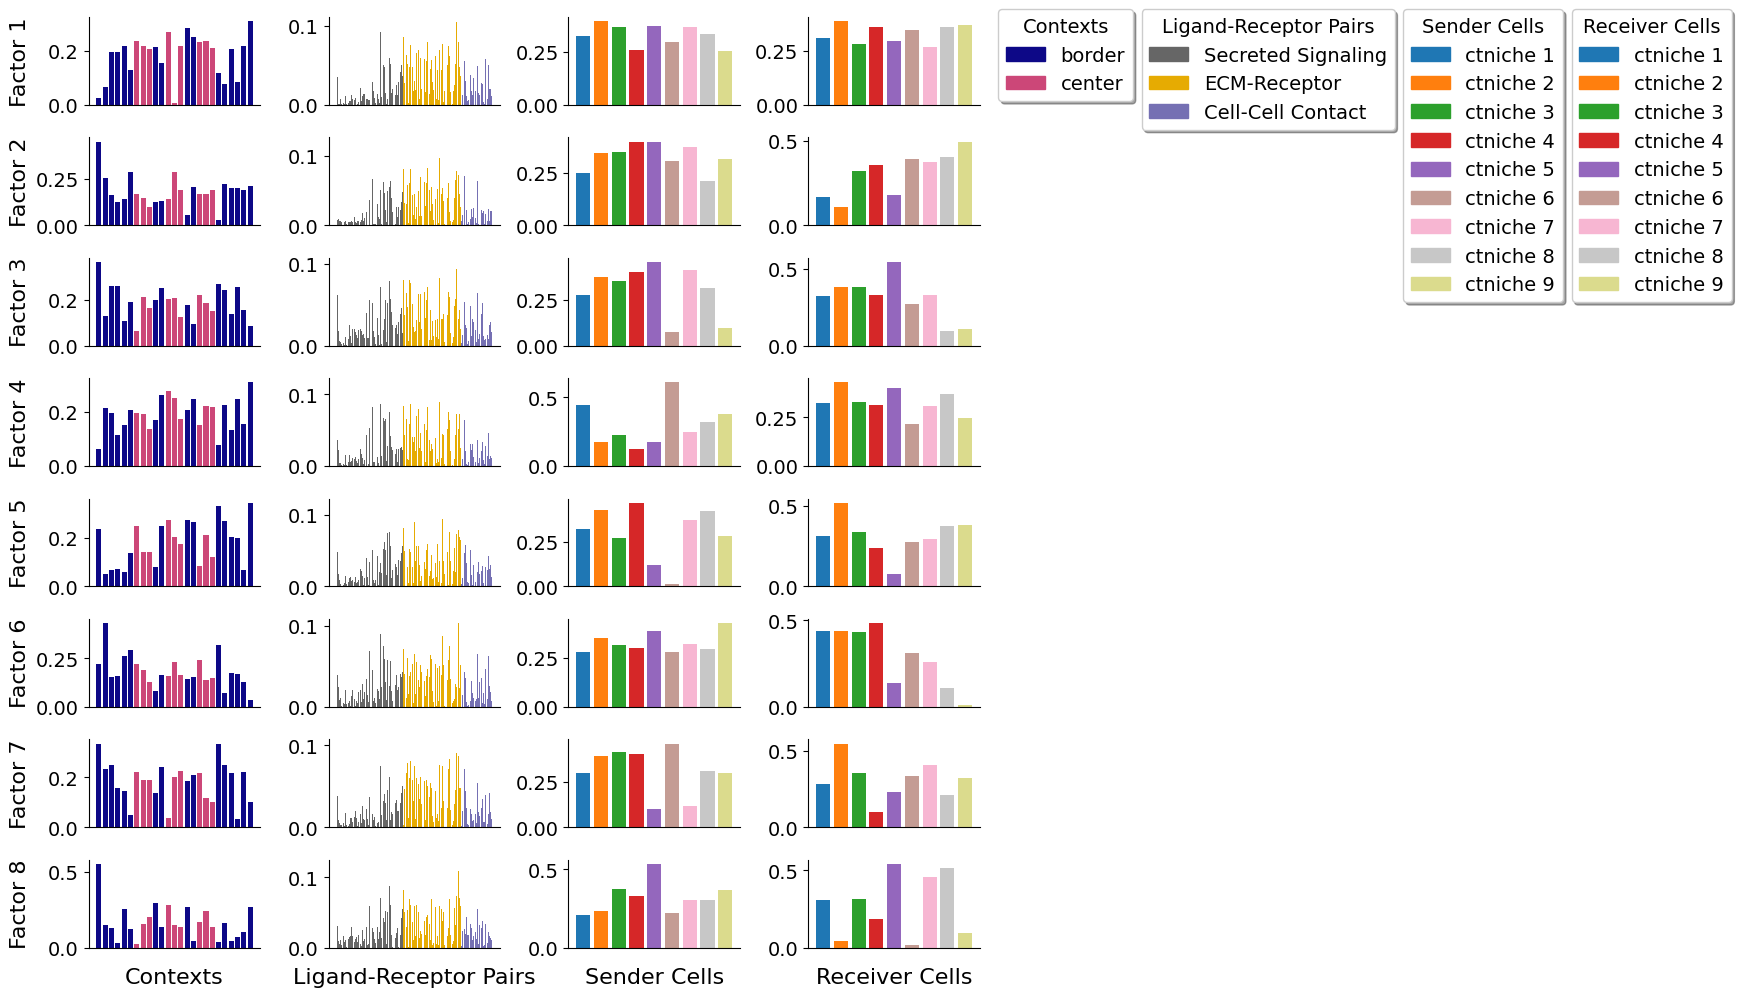

In [34]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             metadata = meta_tf,
                                             sample_col='Element',
                                             group_col='Category',
                                             meta_cmaps=cmaps,
                                             fontsize=14,
                                             filename=None # Put a path (e.g. ./TF.png) to save the figure
                                            )

### Top-5 LR pairs in each factor

In [35]:
for i in range(tensor.rank):
    print(tensor.get_top_factor_elements('Ligand-Receptor Pairs', 'Factor {}'.format(i+1), 5))
    print('')

COL6A2^ITGA11&ITGB1    0.105824
THBS1^CD36             0.105268
LAMB2^DAG1             0.098737
COL1A1^ITGA11&ITGB1    0.098322
COL1A2^CD44            0.098097
Name: Factor 1, dtype: float64

APP^CD74              0.120115
COL4A1^CD44           0.106759
FN1^ITGAV&ITGB1       0.100460
CD99^CD99             0.099189
COL6A1^ITGA1&ITGB1    0.096703
Name: Factor 2, dtype: float64

COL4A1^CD44           0.101958
THBS1^CD36            0.093528
COL6A1^ITGA1&ITGB1    0.092509
LAMB2^ITGA6&ITGB1     0.087914
LAMB2^CD44            0.086940
Name: Factor 3, dtype: float64

COL4A1^CD44           0.116511
COL6A1^ITGA1&ITGB1    0.106284
APP^CD74              0.099292
FN1^CD44              0.097564
COL4A2^ITGA1&ITGB1    0.097428
Name: Factor 4, dtype: float64

LAMB1^ITGA7&ITGB1    0.117206
LAMC1^ITGA1&ITGB1    0.103960
LAMC1^CD44           0.097320
FN1^CD44             0.095531
LAMB1^DAG1           0.094398
Name: Factor 5, dtype: float64

FN1^CD44       0.103508
HSPG2^DAG1     0.103317
LAMB2^DAG1     0.

### Export an excel with all loadings

In [36]:
# Uncomment this to export factor loadings
# tensor.export_factor_loadings('Loadings.xlsx')

## 5 - Visualize CCC patterns in space

Each factor or CCC pattern contains loadings for the context dimension. These loadings could be mapped for each spot or cell depending on what spatial context (grid window) they belong to. Thus, we can visualize the importance of each context in each of the factors, and see how the CCC patterns behave in space.

This behavior in space is useful to understand what set of LR pairs are used by determinant sender-receiver spot pairs in each region of the tissue. Regions with higher scores, indicate that LR pairs of that factor are used more there by the senders and receivers with high loadings.

In [37]:
# Generate columns in the adata.obs dataframe with the loading values of each factor
factor_names = list(tensor.factors['Contexts'].columns)
for f in factor_names:
    adata.obs[f] = adata.obs['grid_cell'].apply(lambda x: float(tensor.factors['Contexts'][f].to_dict()[x]))
    adata.obs[f] = pd.to_numeric(adata.obs[f])

Text(0.5, 0.98, '5x5 Spatial Grid')

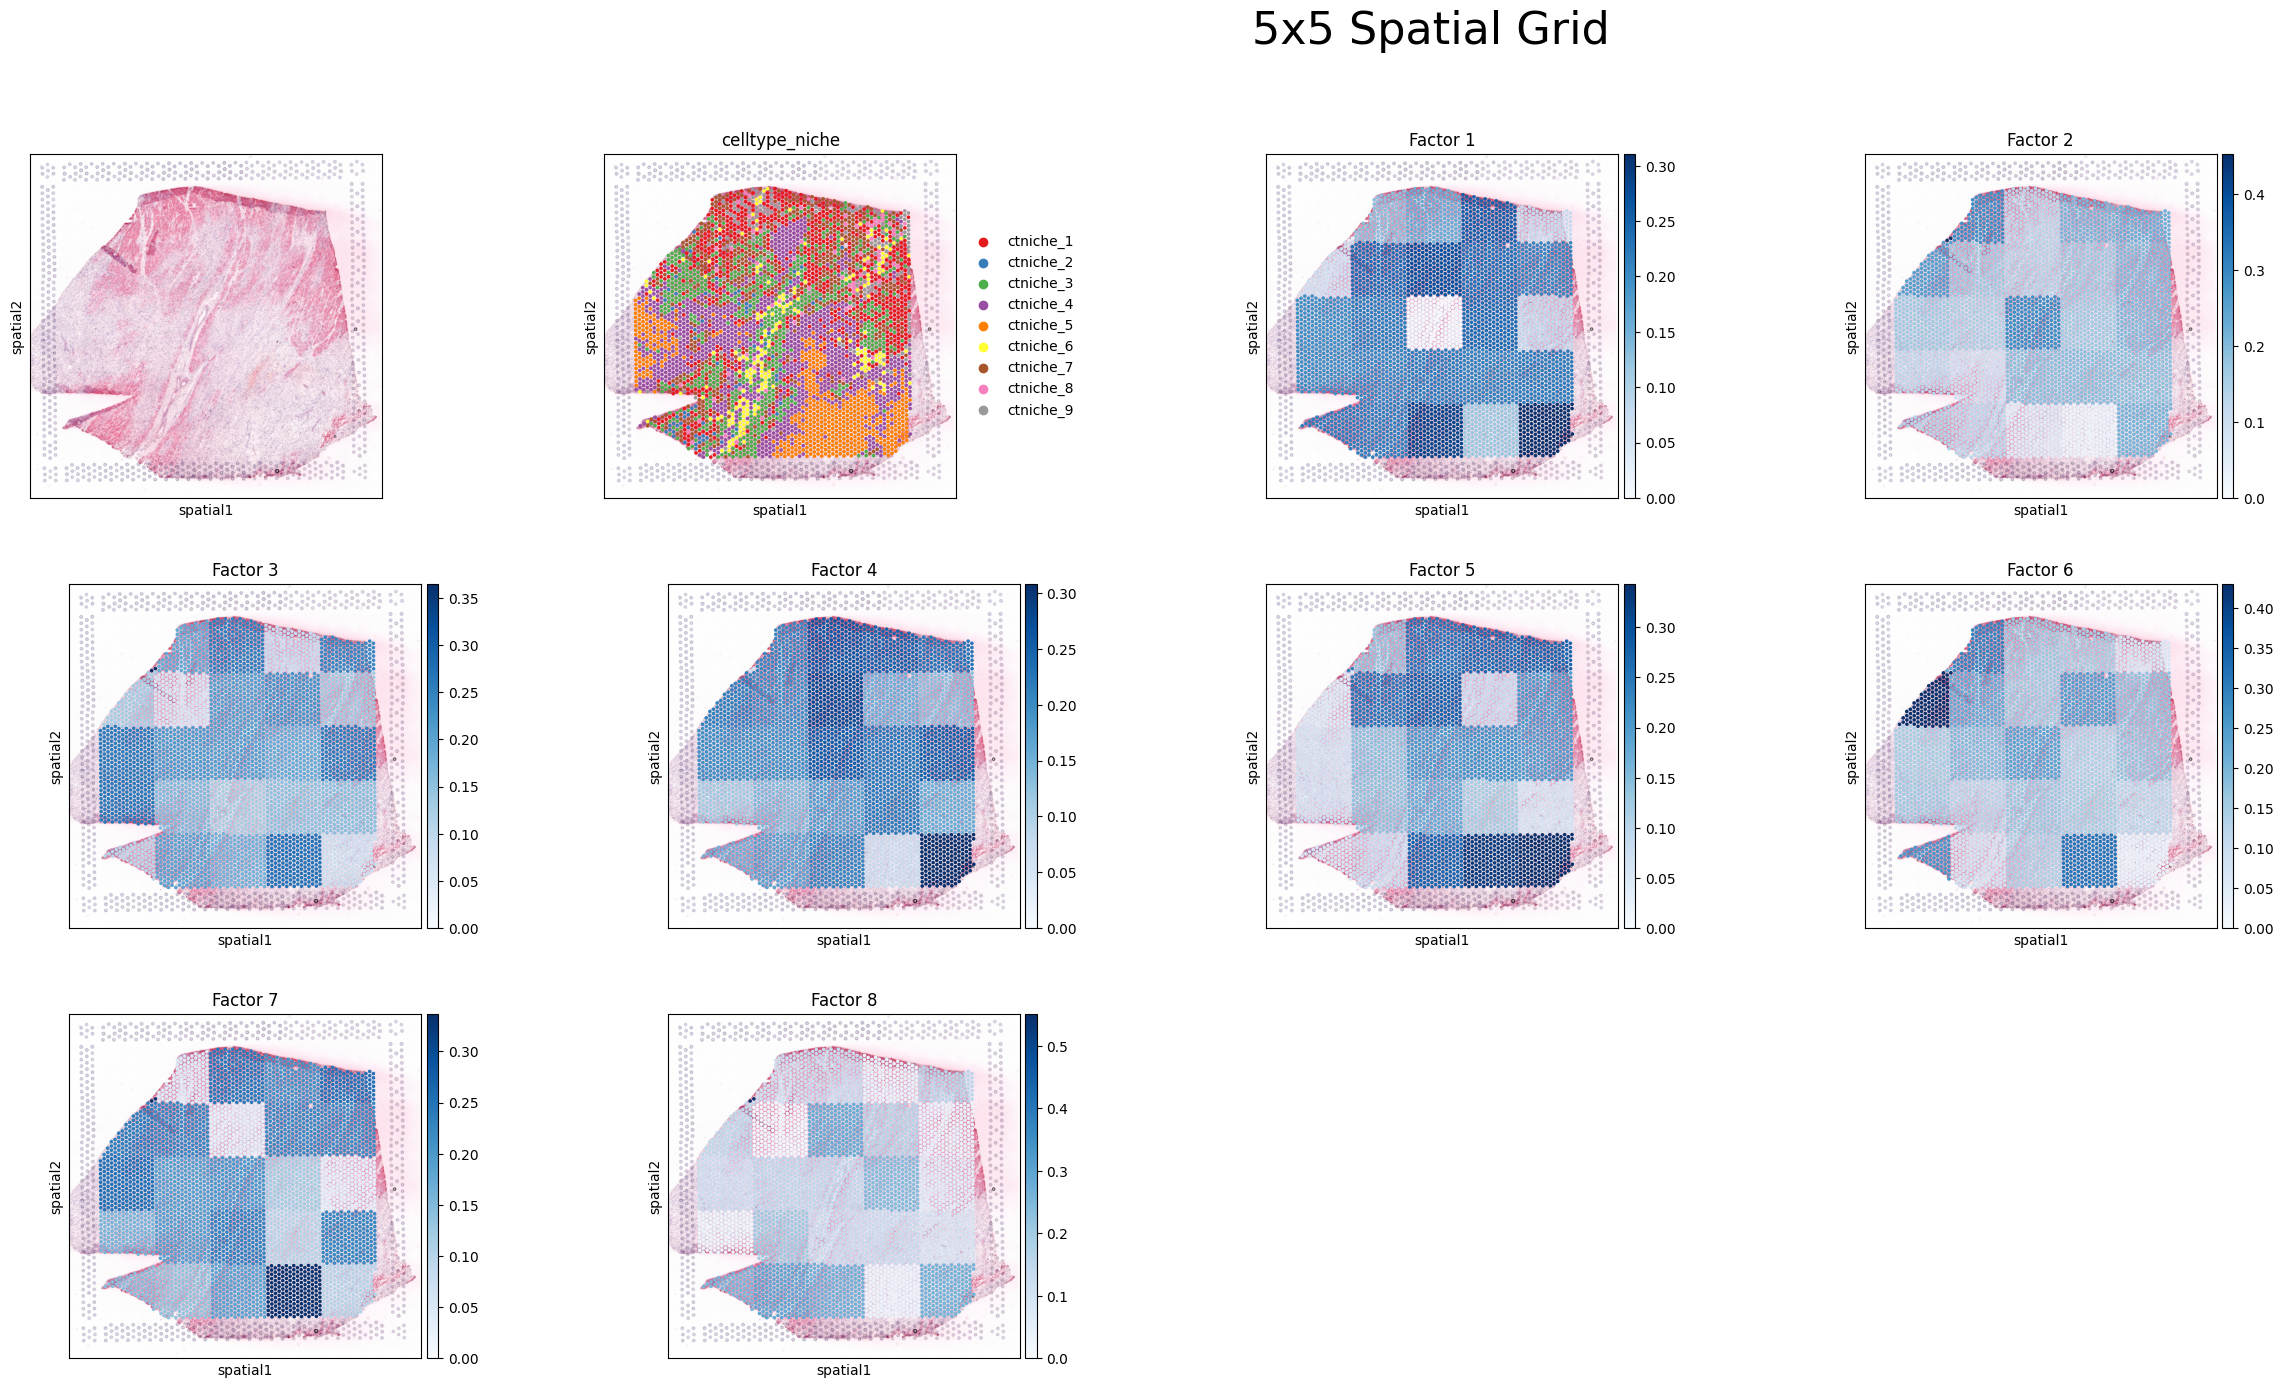

In [38]:
# These columns are used for coloring the tissue regions to associate them with each factor
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche']+factor_names, size=1.3, cmap='Blues', vmin=0.)
plt.suptitle(f'{num_bins}x{num_bins} Spatial Grid', fontsize=32, ha='left')

Then, using the LR pair loadings, we can also identify LR interactions that are key in each factor, and link this with the spatial region with higher scores in the same factor.

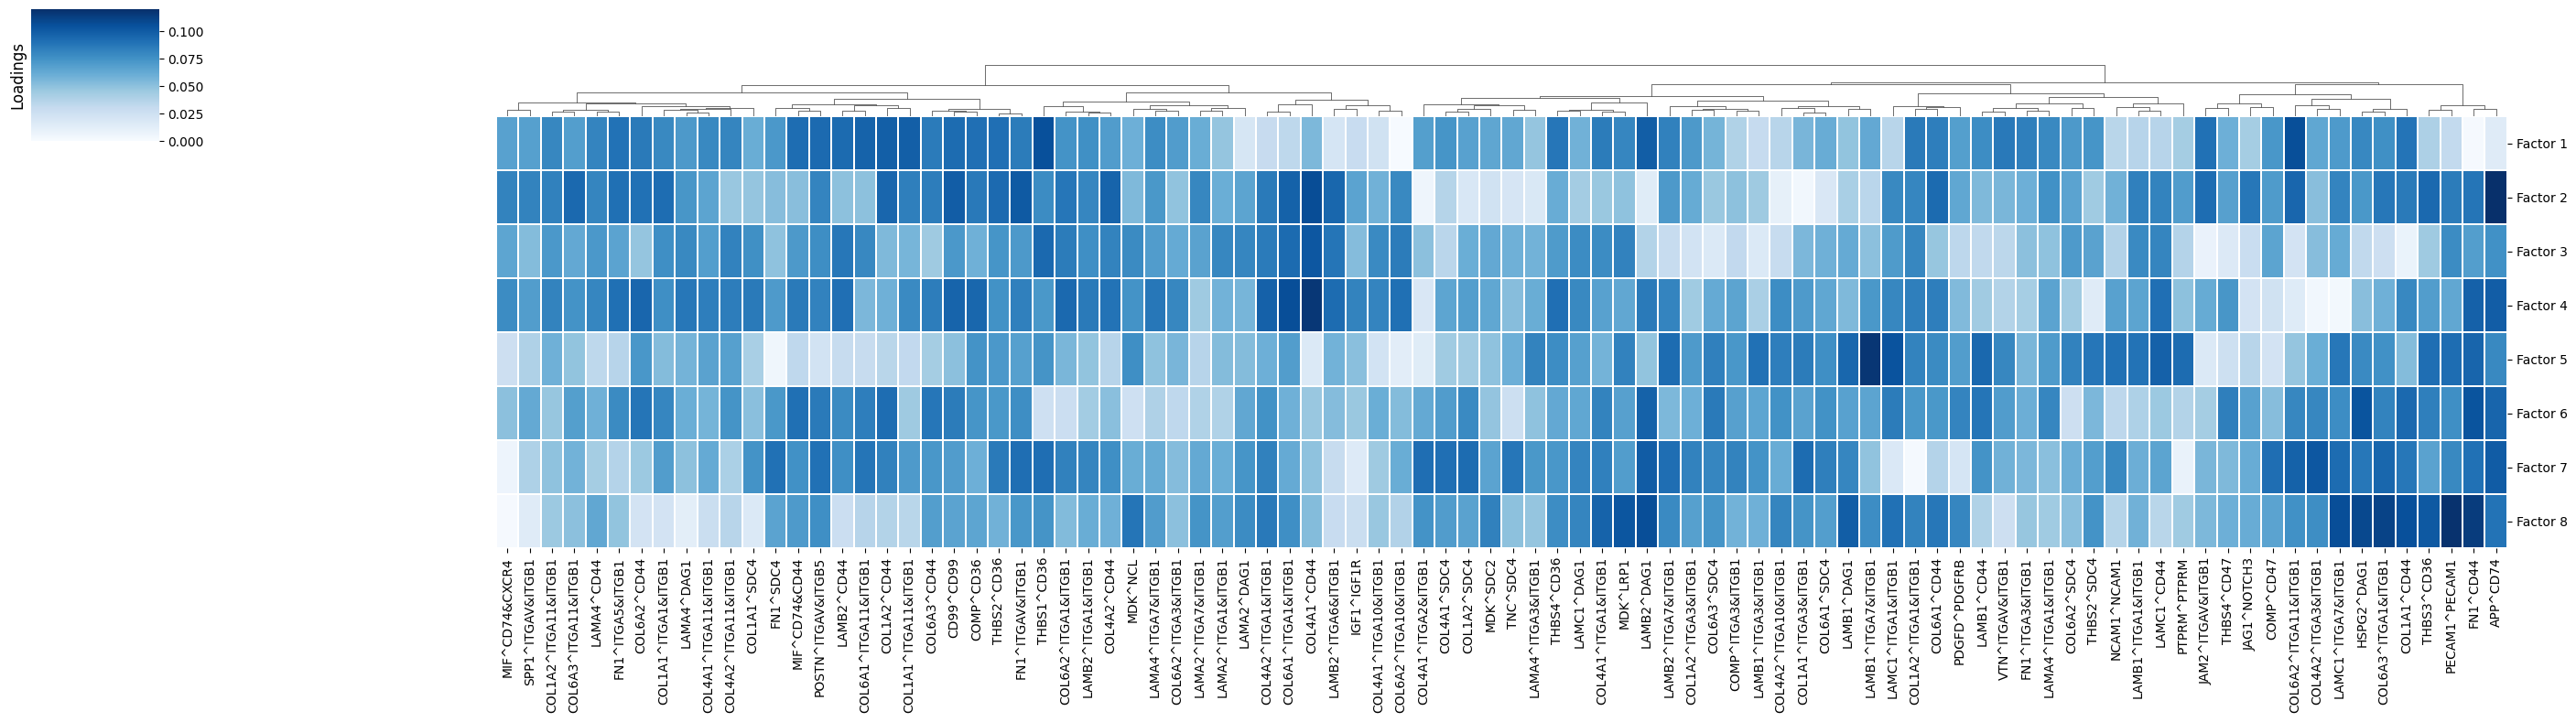

In [39]:
_ = c2c.plotting.loading_clustermap(loadings=tensor.factors['Ligand-Receptor Pairs'],
                                    loading_threshold=0.08,
                                    use_zscore=False,
                                    figsize=(28, 8),
                                    filename=None,
                                    row_cluster=False
                                   )